In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1)
tf.random.set_seed(2)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./checkpoint
./CTG_dataset_autoencoder.ipynb
./CTG_dataset_classification.ipynb
./model2.ckpt.data-00000-of-00001
./model2.ckpt.index
./model3.ckpt.data-00000-of-00001
./model3.ckpt.index
./.ipynb_checkpoints\CTG_dataset_autoencoder-checkpoint.ipynb
./.ipynb_checkpoints\CTG_dataset_classification-checkpoint.ipynb


### Data Loading And Preparation

In [2]:
# Load CTG data with One Hot encoded Class
ctg_data = pd.read_csv('../CTGRawData.csv', sep=';')
ctg_data.describe()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,B,C,D,E,AD,DE,LD,FS,SUSP,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,9.84666,8.187629,1.570085,0.003293,...,0.272342,0.024929,0.038100,0.033866,0.156162,0.118532,0.050329,0.032455,0.092662,1.304327
std,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,18.39688,5.628247,2.499229,0.057300,...,0.445270,0.155947,0.191482,0.180928,0.363094,0.323314,0.218675,0.177248,0.290027,0.614377
min,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.00000,10.800000,3.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.00000,50.700000,16.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [3]:
# Separate Features from labels (last column)
y = ctg_data['NSP']
X = ctg_data.drop('NSP',axis=1).iloc[:,:21]
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

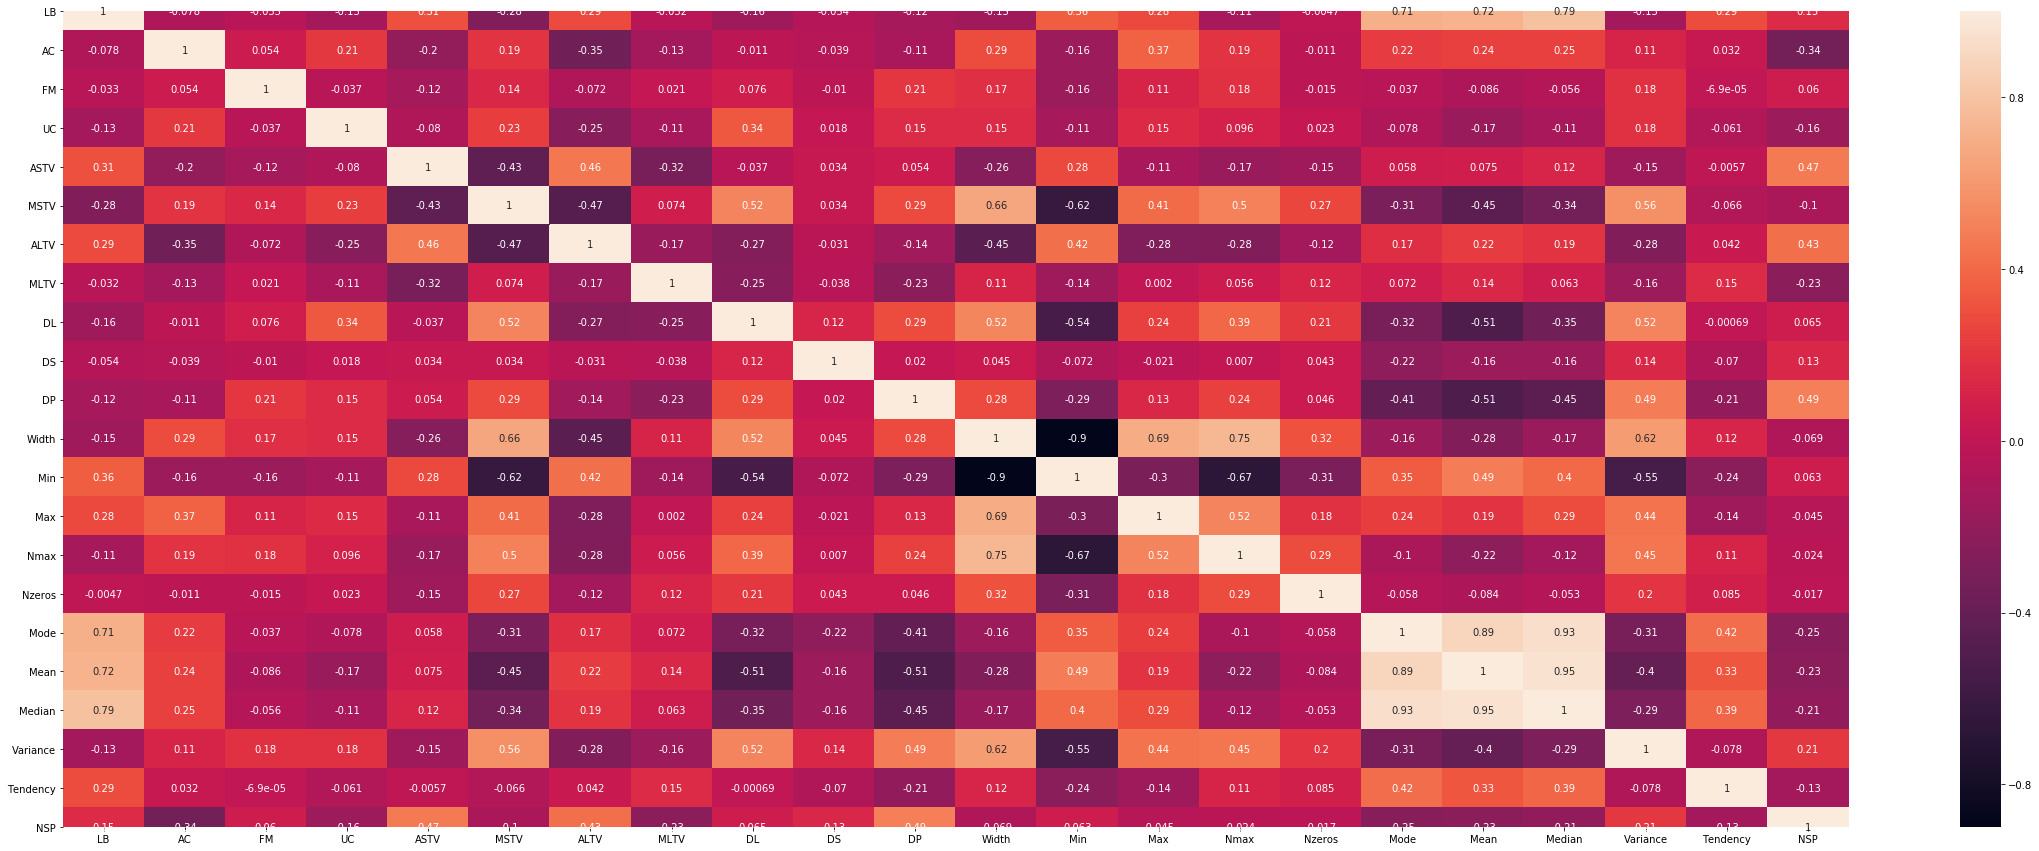

In [7]:
# Plot correlation Matrix
ctg_data_classless = ctg_data.iloc[:,:21]
ctg_data_classless['NSP'] = ctg_data['NSP']
C_mat = ctg_data_classless.corr()
plt.figure(figsize=(40,15))
sns.heatmap(C_mat,square=False,annot=True)
plt.show()

In [4]:
# Normalization of data sets
# X_train_norm = (X_train - X_train.mean()) / X_train.std()
# X_test_norm = (X_test - X_train.mean()) / X_train.std()
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))


### Shallow Learning Classifiers (to compare)

In [9]:
# First: SVM Classifier with RBF kernel (OS14 Exercise)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svm = SVC(kernel = 'rbf', random_state = 0)

# Perform CV to tune parameters for best SVM fit
params_grid = [{'gamma': [5e-1, 3e-1, 1e-1, 1e-2],
                     'C': [ 5, 10, 15, 50, 100]}]

# Perform Cross Validation Grid Search to find best hyperparamters
svm_grid = GridSearchCV(estimator=svm, param_grid=params_grid, cv=5)
svm_grid.fit(X_train_norm, y_train)

# Print training scores
print('Best score for training data:', svm_grid.best_score_,"\n") 
print('Best C:',svm_grid.best_estimator_.C,"\n") 
print('Best Gamma:',svm_grid.best_estimator_.gamma,"\n")

# Select the estimator with the best hyperparameters
final_svm = svm_grid.best_estimator_

# Predict classification with final model
y_pred = final_svm.predict(X_test_norm)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test,y_pred)

print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for SVM: %f" % final_svm.score(X_train_norm, y_train))
print("Testing  set score for SVM: %f" % final_svm.score(X_test_norm  , y_test))

Best score for training data: 0.93 

Best C: 50 

Best Gamma: 0.1 

[[324  11   1]
 [ 14  38   1]
 [  3   5  29]]


              precision    recall  f1-score   support

           1       0.95      0.96      0.96       336
           2       0.70      0.72      0.71        53
           3       0.94      0.78      0.85        37

    accuracy                           0.92       426
   macro avg       0.86      0.82      0.84       426
weighted avg       0.92      0.92      0.92       426

Training set score for SVM: 0.994706
Testing  set score for SVM: 0.917840


In [49]:
# Second: Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, class_weight="balanced_subsample") # try class_weights "balanced" and "balanced_subsample"

# Perform CV to tune n_estimators for best RFC fit
params_grid = [{'n_estimators': [110, 120, 140], 'max_depth':[12,13,14]}]

# Perform Cross Validation Grid Search to find best hyperparamters
rfc_grid = GridSearchCV(estimator=rfc, param_grid=params_grid, cv=5)
rfc_grid.fit(X_train_norm, y_train)

# Print training scores
print('Best score for training data:', rfc_grid.best_score_,"\n") 
print('Best #estimators:',rfc_grid.best_estimator_.n_estimators,"\n") 
print('Best max depth:',rfc_grid.best_estimator_.max_depth,"\n") 

# Select the estimator with the best hyperparameters
final_rfc = rfc_grid.best_estimator_

# Predict classification with final model
y_pred = final_rfc.predict(X_test_norm)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test,y_pred)

print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for RFC: %f" % final_rfc.score(X_train_norm, y_train))
print("Testing  set score for RFC: %f" % final_rfc.score(X_test_norm  , y_test))

# Best performance with Random Forest Classifier: 94%

Best score for training data: 0.9458823529411765 

Best #estimators: 110 

Best max depth: 13 

[[330   4   2]
 [ 12  39   2]
 [  2   3  32]]


              precision    recall  f1-score   support

           1       0.96      0.98      0.97       336
           2       0.85      0.74      0.79        53
           3       0.89      0.86      0.88        37

    accuracy                           0.94       426
   macro avg       0.90      0.86      0.88       426
weighted avg       0.94      0.94      0.94       426

Training set score for RFC: 0.998235
Testing  set score for RFC: 0.941315


### Deep Learning Classifiers
Preprocessing and auxiliar functions

In [5]:
# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

In [60]:
# Callbacks and plot functions
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
  plt.legend()

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')



....................................................................................................
.0.2549792859755771 0.8967136


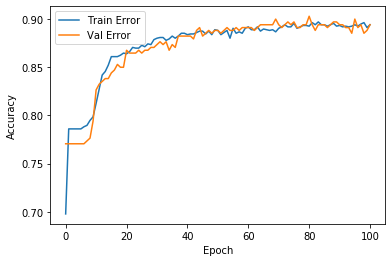

In [110]:
# DNN model for classification
# Define Model 1 - Small "shallow" 1-hidden-layer model
def build_model1():
  model = keras.Sequential([
    layers.Dense(12, activation=tf.nn.relu, input_shape=[len(X_train_norm.keys())]),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

model = build_model1()
EPOCHS = 1000
history = model.fit(np.array(X_train_norm), y_train_oh, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, rlrop,PrintDot()])

plot_history(history)

test_loss, test_acc = model.evaluate(np.array(X_test_norm), y_test_oh, verbose=0)
print(test_loss,test_acc)

array([[0.5       , 0.        , 0.        , 0.52941176, 0.2       ,
        0.17647059, 0.01098901, 0.37080868, 0.08333333, 0.        ,
        0.        , 0.30635838, 0.42201835, 0.25862069, 0.27777778,
        0.        , 0.5984252 , 0.55963303, 0.55045872, 0.01574803,
        1.        ],
       [0.37037037, 0.73076923, 0.00531915, 0.58823529, 0.54666667,
        0.33823529, 0.        , 0.00591716, 0.08333333, 0.        ,
        0.        , 0.47398844, 0.31192661, 0.40517241, 0.16666667,
        0.        , 0.59055118, 0.55045872, 0.57798165, 0.0511811 ,
        0.5       ],
       [0.35185185, 0.07692308, 0.0141844 , 0.17647059, 0.13333333,
        0.29411765, 0.        , 0.16765286, 0.33333333, 0.        ,
        0.        , 0.70520231, 0.02752294, 0.48275862, 0.5       ,
        0.        , 0.65354331, 0.4587156 , 0.49541284, 0.33070866,
        0.5       ],
       [0.48148148, 0.        , 0.11524823, 0.        , 0.18666667,
        0.85294118, 0.        , 0.09861933, 0.6666666


.....................................................................
Epoch 00070: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
..........
Epoch 00080: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
426/426 [==============================] - 0s 91us/sample - loss: 0.2296 - accuracy: 0.9178


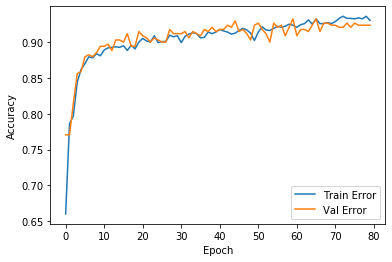

In [37]:
# Define Model 2 - Medium model
def build_model2():
  model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, input_shape=[len(X_train_norm.keys())]),
    layers.Dense(16,activation=tf.nn.relu),
    layers.Dense(16,activation=tf.nn.relu),
    layers.Dense(12,activation=tf.nn.relu),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

model2 = build_model2()
EPOCHS = 1000
history2 = model2.fit(X_train_norm, y_train_oh, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, rlrop, PrintDot()])

plot_history(history2)
test_loss2, test_acc2 = model2.evaluate(X_test_norm, y_test_oh)


.............................................
Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
...................
Epoch 00065: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
..........
Epoch 00075: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
426/426 [==============================] - 0s 101us/sample - loss: 0.1892 - accuracy: 0.9225


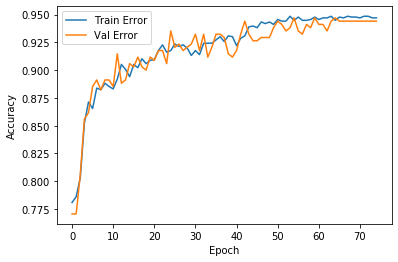

In [41]:
# Define Model 3 - Very Big model
def build_model3():
  model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, input_shape=[len(X_train_norm.keys())]),
    layers.Dense(32,activation=tf.nn.relu),
    layers.Dense(32,activation=tf.nn.relu),
    layers.Dense(16,activation=tf.nn.relu),
    layers.Dense(16,activation=tf.nn.relu),
    layers.Dense(12,activation=tf.nn.relu),
    layers.Dense(8,activation=tf.nn.relu),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model
model3 = build_model3()
EPOCHS = 1000
history3 = model3.fit(X_train_norm, y_train_oh, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, rlrop, PrintDot()])

plot_history(history3)
test_loss3, test_acc3 = model3.evaluate(X_test_norm, y_test_oh)

In [42]:
hist = pd.DataFrame(history.history)
hist2 = pd.DataFrame(history2.history)
hist3 = pd.DataFrame(history3.history)
pd.concat([hist.tail(5),hist2.tail(5),hist3.tail(5)], axis=1)

,loss,accuracy,val_loss,val_accuracy,lr,loss,accuracy,val_loss,val_accuracy,lr,loss,accuracy,val_loss,val_accuracy,lr
44,0.290122,0.875735,0.290566,0.864706,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,0.288220,0.876471,0.288722,0.864706,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0.286613,0.875000,0.287141,0.867647,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,0.285075,0.873529,0.285880,0.864706,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0.283787,0.879412,0.284004,0.864706,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115382,0.947059,0.146276,0.944118,0.00001
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115311,0.948529,0.145839,0.944118,0.00001
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115300,0.948529,0.145810,0.944118,0.00001
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115401,0.947059,0.146008,0.944118,0.00001
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115356,0.947059,0.145457,0.944118,0.00001


In [62]:
# Train models 2 and 3 on full dataset and evaluate
checkpoint = keras.callbacks.ModelCheckpoint(filepath="./model2.ckpt", save_best_only=True, save_weights_only=True, verbose=0)
model2 = build_model2()
history2 = model2.fit(X_train_norm, y_train_oh, epochs=100,
                    validation_split = 0.05, verbose=0, callbacks=[early_stop, checkpoint, PrintDot()])
hist2 = pd.DataFrame(history2.history)

checkpoint = keras.callbacks.ModelCheckpoint(filepath="./model3.ckpt", save_best_only=True, save_weights_only=True, verbose=0)
model3 = build_model3()
history3 = model3.fit(X_train_norm, y_train_oh, epochs=100,
                    validation_split = 0.05, verbose=0, callbacks=[early_stop, checkpoint, PrintDot()])
hist3 = pd.DataFrame(history3.history)

print(pd.concat([hist2.tail(5),hist3.tail(5)], axis=1))

# Load best weights.
model2_best = build_model2()
model2_best.load_weights("./model2.ckpt")
model3_best = build_model3()
model3_best.load_weights("./model3.ckpt")


test_loss2, test_acc2 = model2.evaluate(X_test_norm, y_test_oh)
test_loss3, test_acc3 = model3.evaluate(X_test_norm, y_test_oh)
test_loss2_best, test_acc2_best = model2_best.evaluate(X_test_norm, y_test_oh)
test_loss3_best, test_acc3_best = model3_best.evaluate(X_test_norm, y_test_oh)



................................................        loss  accuracy  val_loss  val_accuracy      loss  accuracy  val_loss  \
36  0.205689  0.912074  0.171796      0.929412       NaN       NaN       NaN   
37  0.205176  0.905882  0.194386      0.929412       NaN       NaN       NaN   
38  0.201127  0.911455  0.184431      0.929412       NaN       NaN       NaN   
39  0.198369  0.907121  0.172487      0.929412       NaN       NaN       NaN   
40  0.196323  0.914551  0.178521      0.929412       NaN       NaN       NaN   
43       NaN       NaN       NaN           NaN  0.201060  0.908359  0.159901   
44       NaN       NaN       NaN           NaN  0.195496  0.910836  0.159571   
45       NaN       NaN       NaN           NaN  0.195423  0.907740  0.236964   
46       NaN       NaN       NaN           NaN  0.199119  0.910217  0.154113   
47       NaN       NaN       NaN           NaN  0.195297  0.914551  0.161263   

    val_accuracy  
36           NaN  
37           NaN  
38          

### Results of Model Size Comparison
#### Model 2 - Medium sized network - accuracy: 0.9085
#### Model 3 - Big sized network    - accuracy: 0.8991

#### Last: M2: 09061 - M3: 0.9178 - M2Best: 0.9085 - M3Best: 0.9272
____________________________________________________________________________

In [65]:
# Keep model3, it has "better" accuracy.
# Next, try different regularization values for L2 and L1
# First L1 regularization
def build_model4(penalization):
  model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1(penalization), input_shape=[len(X_train_norm.keys())]),
    layers.Dense(32,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1(penalization)),
    layers.Dense(32,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1(penalization)),
    layers.Dense(16,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1(penalization)),
    layers.Dense(16,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1(penalization)),
    layers.Dense(12,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1(penalization)),
    layers.Dense(8,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1(penalization)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

# Test different penalty values.
penalizations = [0,0.000001, 0.00001, 0.000015]
acc_history = np.zeros(len(penalizations))

for idx,p in enumerate(penalizations):
    EPOCHS = 1000
    model = build_model4(p)
    history = model.fit(X_train_norm, y_train_oh, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()], shuffle=False)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    acc = hist.tail(1).val_accuracy.item()
    acc_history[idx] = acc
    print('Accuracy: ', acc)
print("Accuracy history: ", acc_history)


..............................................................Accuracy:  0.9205882549285889


C:\Users\Tomas\Anaconda3\envs\tensorflow_2\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version



................................Accuracy:  0.8823529481887817

......................................................................................Accuracy:  0.9117646813392639

..........................................................................Accuracy:  0.8999999761581421
Accuracy history:  [0.92058825 0.88235295 0.91176468 0.89999998]


In [68]:
# Second: L2 regularization:
def build_model5(penalization):
  model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization), input_shape=[len(X_train_norm.keys())]),
    layers.Dense(32,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(32,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(16,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(16,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(12,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(8,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

# Test different penalty values.
penalizations = [0,0.000001,0.00001, 0.0001, 0.001]
acc_history = np.zeros(len(penalizations))

for idx,p in enumerate(penalizations):
    EPOCHS = 1000
    model = build_model5(p)
    history = model.fit(X_train_norm, y_train_oh, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()], shuffle=False)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    acc = hist.tail(1).val_accuracy.values[0]
    acc_history[idx] = acc
    print('Accuracy: ', acc)
    print('Epochs: ', hist.epoch.tail(1).values[0])
print("Accuracy history: ", acc_history)


........................................................Accuracy:  0.9235293865203857
Epochs:  55

.....................................................Accuracy:  0.908823549747467
Epochs:  52

...........................................................Accuracy:  0.908823549747467
Epochs:  58

...............................................................................Accuracy:  0.9176470637321472
Epochs:  78

........................................................................Accuracy:  0.9117646813392639
Epochs:  71
Accuracy history:  [0.92352939 0.90882355 0.90882355 0.91764706 0.91176468]


In [69]:
# Evaluate on full training set
# Model 2 with l2 regularization with C = 0.00001 -> Model 5

model5 = build_model5(0)
history5 = model5.fit(X_train_norm, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[PrintDot()])
hist5 = pd.DataFrame(history5.history)

test_loss5, test_acc5 = model5.evaluate(X_test_norm, y_test_oh)


426/426 [==============================] - 0s 145us/sample - loss: 0.2214 - accuracy: 0.9038


In [90]:
# Third: L1L2 regularization:
def build_model6(l1, l2):
  model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2), input_shape=[len(X_train_norm.keys())]),
    layers.Dense(32,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
    layers.Dense(32,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
    layers.Dense(16,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
    layers.Dense(16,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
    layers.Dense(12,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
    layers.Dense(8,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

# Test different penalty values.
penalizations_l1 = [0, 0]
penalizations_l2 = [0,0, 0]
acc_history = np.zeros((len(penalizations_l1),len(penalizations_l2)))

for idx_l1,p_l1 in enumerate(penalizations_l1):
    for idx_l2,p_l2 in enumerate(penalizations_l2):
        EPOCHS = 1000
        model = build_model6(p_l1,p_l2)
        history = model.fit(X_train_norm, pd.DataFrame(y_train_oh), epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()], shuffle=False)
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        acc = hist.tail(1).val_accuracy.values[0]
        acc_history[idx_l1,idx_l2] = acc
        print('\nAccuracy: ', acc)
        print('Epochs: ', hist.epoch.tail(1).values[0])
print("Accuracy history: ", acc_history)


...................................................................
Accuracy:  0.8970588445663452
Epochs:  66

.................................................................................
Accuracy:  0.9117646813392639
Epochs:  80

.......................................................................................
Accuracy:  0.9323529601097107
Epochs:  86

................................................
Accuracy:  0.9176470637321472
Epochs:  47

.................................................................................
Accuracy:  0.9147058725357056
Epochs:  80

....................................................................................................
...........
Accuracy:  0.9264705777168274
Epochs:  110
Accuracy history:  [[0.89705884 0.91176468 0.93235296]
 [0.91764706 0.91470587 0.92647058]]


In [ ]:
# Evaluate on full training set
# Model 3 with l1l2 regularization with Cl1 = 0.00001 and Cl2 = 

model6 = build_model6(0)
history6 = model6.fit(X_train_norm, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[PrintDot()])
hist5 = pd.DataFrame(history5.history)

test_loss6, test_acc6 = model6.evaluate(X_test_norm, y_test_oh)

### Results of Regularziaton strategy comparison
#### Model 3 - Best result still with no regularization 
#### accuracy: 0.9038..
_______________________________________________________________________________________________

In [94]:
## Model 7 - Adding dropout layers
# Model definition - One dropout layer for every dense layer, on model 3
def build_model7(dropout):
  model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, input_shape=[len(X_train_norm.keys())]),
    layers.Dropout(dropout),
    layers.Dense(32,activation=tf.nn.relu),
    layers.Dropout(dropout),
    layers.Dense(32,activation=tf.nn.relu),
    layers.Dropout(dropout),
    layers.Dense(16,activation=tf.nn.relu),
    layers.Dropout(dropout),
    layers.Dense(16,activation=tf.nn.relu),
    layers.Dropout(dropout),
    layers.Dense(12,activation=tf.nn.relu),
    layers.Dropout(dropout),
    layers.Dense(8,activation=tf.nn.relu),
    layers.Dropout(dropout),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

# Test different dropout values.
dropouts = [0.05, 0.07, 0.09, 0.1, 0.12]
acc_history = np.zeros(len(dropouts))

for idx,p in enumerate(dropouts):
    EPOCHS = 1000
    model = build_model7(p)
    history = model.fit(X_train_norm, y_train_oh, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()], shuffle=False)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    acc = hist.tail(1).val_accuracy.values[0]
    acc_history[idx] = acc
    print('Accuracy: ', acc)
    print('Epochs: ', hist.epoch.tail(1).values[0])
print("Accuracy history: ", acc_history)


.......................................................Accuracy:  0.8999999761581421
Epochs:  54

.............................................................Accuracy:  0.9147058725357056
Epochs:  60

....................................................................................................
....Accuracy:  0.8970588445663452
Epochs:  103

.........................................................................Accuracy:  0.9117646813392639
Epochs:  72

.....................................................................Accuracy:  0.9264705777168274
Epochs:  68
Accuracy history:  [0.89999998 0.91470587 0.89705884 0.91176468 0.92647058]


In [27]:
model7 = build_model7(0.11)
history7 = model7.fit(X_train_norm, y_train_oh, epochs=93,
                    validation_split = 0, verbose=0, callbacks=[PrintDot()])
hist7 = pd.DataFrame(history7.history)

print(hist7.tail())

test_loss7, test_acc7 = model7.evaluate(X_test_norm, y_test_oh)
print(test_loss7,test_acc7)


.............................................................................................        loss  accuracy
88  0.094466  0.957647
89  0.100841  0.958235
90  0.098882  0.960000
91  0.090418  0.960000
92  0.098056  0.961176
426/426 [==============================] - 0s 262us/sample - loss: 0.3411 - accuracy: 0.9061
0.34109446532289744 0.9061033


### Results of Regularziaton with Dropout
#### Model 6 - Medium size network with Dropout Layers with rate = 0.11 
#### accuracy: 0.9131
_________________________

In [36]:
# Try Adding weights to the classes, because class imbalance
# From TF documentation of Model.fit()
# class_weight: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). 
# This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

# Check classes ratio
print(y_test.value_counts()/y_test.size)
# N = 77%, S = 16%, P = 7%
print(0.767606/(y_test.value_counts()/y_test.size))
# Rounding: N=1, S=5, P=10
weights = {0:1, 1:4.88, 2:10.21}

model5 = build_model5(0.00001)
history5 = model5.fit(X_train_norm, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[PrintDot()], class_weight=weights)
hist5 = pd.DataFrame(history5.history)

test_loss5, test_acc5 = model5.evaluate(X_test_norm, y_test_oh)

model6 = build_model6(0.11)
history6 = model6.fit(X_train_norm, y_train_oh, epochs=99,
                    validation_split = 0, verbose=0, callbacks=[PrintDot()], class_weight=weights)
hist6 = pd.DataFrame(history6.history)

print(hist6.tail())

test_loss6, test_acc6 = model6.evaluate(X_test_norm, y_test_oh)
print(test_loss6,test_acc6)

1    0.767606
2    0.157277
3    0.075117
Name: NSP, dtype: float64
1     1.000000
2     4.880599
3    10.218755
Name: NSP, dtype: float64

426/426 [==============================] - 0s 187us/sample - loss: 0.4085 - accuracy: 0.8967

...................................................................................................        loss  accuracy
94  0.384376  0.936471
95  0.306285  0.936471
96  0.268078  0.937059
97  0.333053  0.922353
98  0.261808  0.934118
426/426 [==============================] - 0s 295us/sample - loss: 0.3086 - accuracy: 0.8967
0.30860571094521894 0.8967136


### Results of Class Weight with Model 5 - L2 Regularization and Model 6 - Dropout
#### Model 5 - Medium size network with L2 regularization with C=0.00001 
#### Model 6 - Medium size network with Dropout Layers with rate = 0.11 
#### accuracy: 0.89
_________________________

In [ ]:
# Try Ensemble Methods to improve accuracy.

In [55]:
filepath=os.path
filepath

<module 'ntpath' from 'C:\\Users\\Tomas\\Anaconda3\\envs\\tensorflow_2\\lib\\ntpath.py'>

In [52]:
os.path.dirname()

TypeError: dirname() missing 1 required positional argument: 'p'

In [77]:
pd.DataFrame(y_train_oh)

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
1695,1.0,0.0,0.0
1696,1.0,0.0,0.0
1697,1.0,0.0,0.0
1698,1.0,0.0,0.0
